In [2]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
out_path = "../out/bert_student/m5_k10"

image_save_path = os.path.join('.', 'plots'); os.makedirs(image_save_path, exist_ok=True)

results_dict = {}

shen_loss_weights = ['0.5', '1', '2']
learning_rates = ['0.002', '0.0002', '0.00004']
epochs_list = ['2', '5', '10']

for shen_loss_weight in shen_loss_weights:
    if shen_loss_weight not in results_dict:
        results_dict[shen_loss_weight] = {}
    for learning_rate in learning_rates:
        if learning_rate not in results_dict[shen_loss_weight]:
            results_dict[shen_loss_weight][learning_rate] = {}
        for epochs in epochs_list:
            version_identifier = f"shen_{shen_loss_weight}_lr{learning_rate}_e{epochs}"
            results_path = os.path.join(out_path, version_identifier, "results/results.json")
            try:
                with open(results_path, 'r') as file:
                    results = json.load(file)
                    if epochs not in results_dict[shen_loss_weight][learning_rate]:
                        results_dict[shen_loss_weight][learning_rate][epochs] = {}
                    results_dict[shen_loss_weight][learning_rate][epochs] = results
            except FileNotFoundError:
                print(f"Results file not found for version: {version_identifier}")
            except json.JSONDecodeError:
                print(f"Error decoding JSON for version: {version_identifier}")


In [4]:
results_dict['0.5']['0.002']['2'].keys()

dict_keys(['y_true', 'y_pred', 'y_prob', 'predictive_variance', 'average_inference_time', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'auc_score', 'nll_score', 'brier_score', 'ece_score', 'bald_score'])

In [5]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "serif"

In [6]:
# per shen loss weight, plot learning rate vs epochs vs auc
# can then plot the three graphs in column type sub figs in latex with name being the lambda value
for shen_loss_weight in shen_loss_weights:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # fig.suptitle(f"$\lambda$ = {shen_loss_weight}")
    
    for i, learning_rate in enumerate(learning_rates):
        f1_values = [results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] for epochs in epochs_list]
        axs[i].bar(epochs_list, f1_values)
        # add actual values on top of bars
        for j, f1 in enumerate(f1_values):
            axs[i].text(j, f1, f"{f1:.3f}", ha='center', va='bottom')
        learning_rate_float = float(learning_rate)
        # Format learning rate in scientific notation for the title
        formatted_learning_rate = f"{learning_rate_float:.0e}"
        axs[i].set_title(f"Learning Rate = {formatted_learning_rate}")
        if i == 1:
            axs[i].set_xlabel("Epochs")
        if i == 0:
            axs[i].set_ylabel("F1")
        axs[i].set_ylim([0.95, 1])
    plt.tight_layout()
    plt.savefig(os.path.join(image_save_path, f"plot_shen_loss_weight_{shen_loss_weight}.pdf"))
    plt.close(fig)

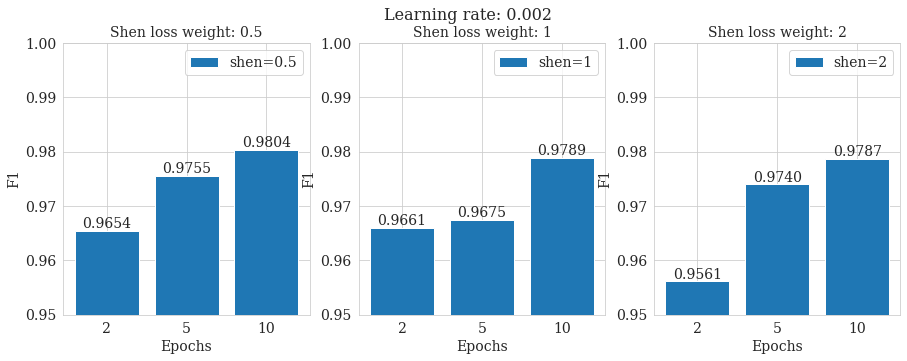

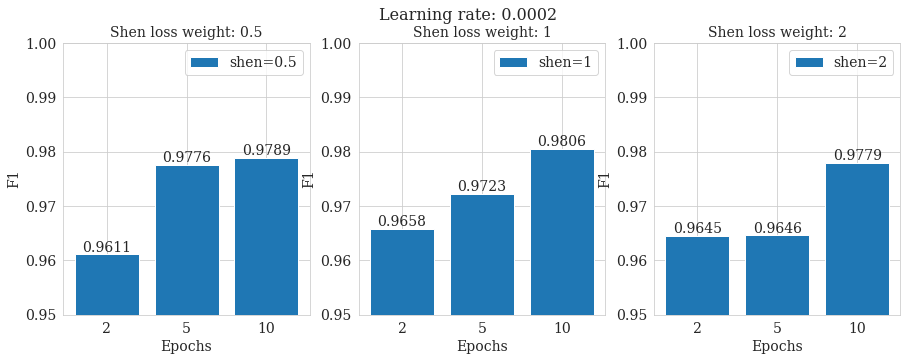

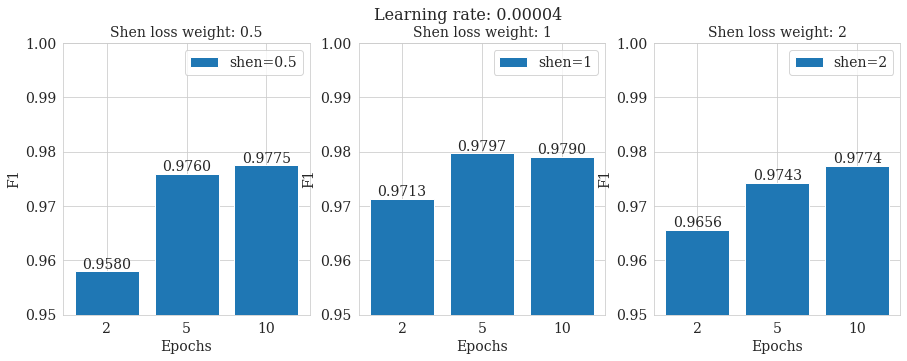

In [7]:
# per learning rate, plot shen loss weight vs epochs vs auc
for learning_rate in learning_rates:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Learning rate: {learning_rate}")
    for i, shen_loss_weight in enumerate(shen_loss_weights):
        f1_values = [results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] for epochs in epochs_list]
        axs[i].bar(epochs_list, f1_values, label=f"shen={shen_loss_weight}")
        # add actual values on top of bars
        for j, f1 in enumerate(f1_values):
            axs[i].text(j, f1, f"{f1:.4f}", ha='center', va='bottom')
        axs[i].set_title(f"Shen loss weight: {shen_loss_weight}")
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel("F1")
        axs[i].set_ylim([0.95, 1])
        axs[i].legend()
    plt.show()

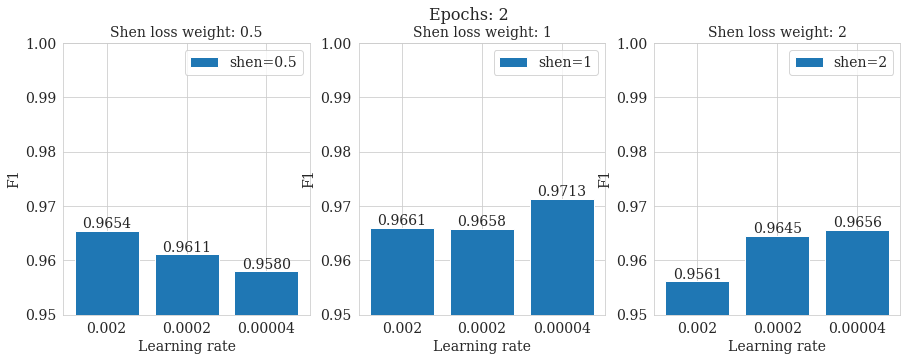

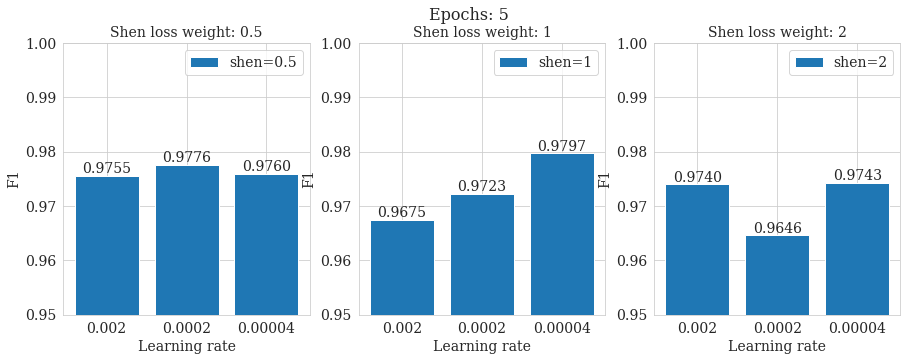

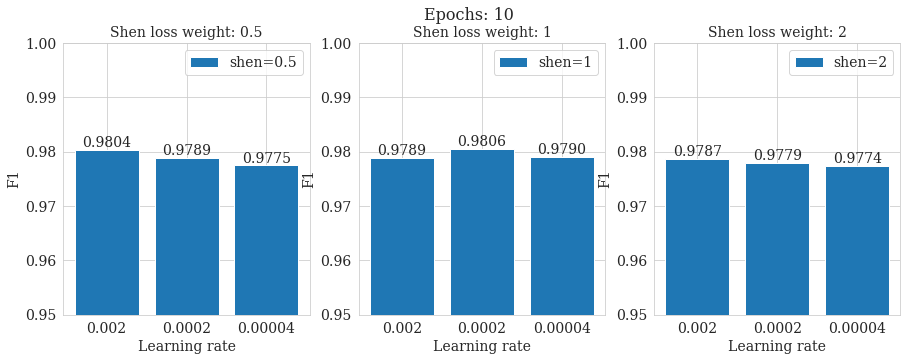

In [8]:
# per epochs, plot shen loss weight vs learning rate vs auc
for epochs in epochs_list:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Epochs: {epochs}")
    for i, shen_loss_weight in enumerate(shen_loss_weights):
        f1_values = [results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] for learning_rate in learning_rates]
        axs[i].bar(learning_rates, f1_values, label=f"shen={shen_loss_weight}")
        # add actual values on top of bars
        for j, f1 in enumerate(f1_values):
            axs[i].text(j, f1, f"{f1:.4f}", ha='center', va='bottom')
        axs[i].set_title(f"Shen loss weight: {shen_loss_weight}")
        axs[i].set_xlabel("Learning rate")
        axs[i].set_ylabel("F1")
        axs[i].set_ylim([0.95, 1])
        axs[i].legend()
    plt.show()

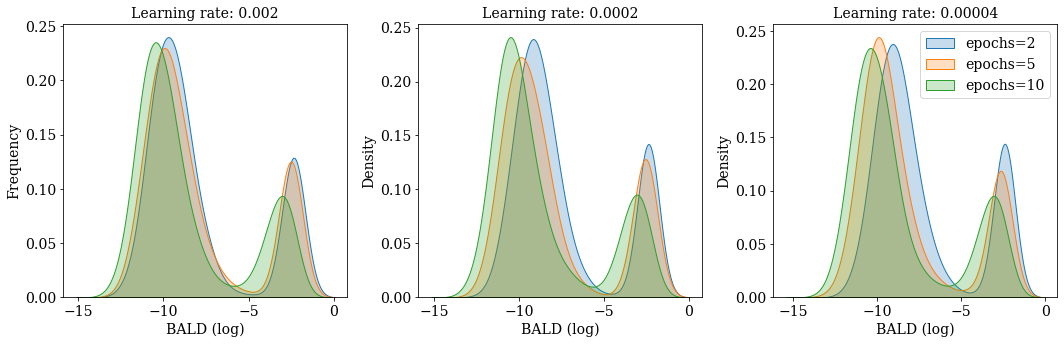

In [87]:
# for shen loss weight = 1, analyze bald score distribution per learning rate and epochs
shen_loss_weight = '1'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# plot layered bald kde plots for each learning rate
for i, learning_rate in enumerate(learning_rates):
    bald_scores = [np.log(results_dict[shen_loss_weight][learning_rate][epochs]['bald_score']) for epochs in epochs_list]
    for j, bald_score in enumerate(bald_scores):
        # axs[i].hist(bald_score, bins=20, alpha=0.5, label=f"epochs={epochs_list[j]}")
        # density plot
        sns.kdeplot(bald_score, ax=axs[i], label=f"epochs={epochs_list[j]}", fill=True)
    axs[i].set_title(f"Learning rate: {learning_rate}")
    axs[i].set_xlabel("BALD (log)")
    if i == 0:
        axs[i].set_ylabel("Frequency")
    # single legend for all subplots to the right of the last subplot
    if i == 2:
        axs[i].legend()
plt.tight_layout()

In [96]:
results_dict['1']['0.0002']['2']['ece_score']

0.08364514882115409

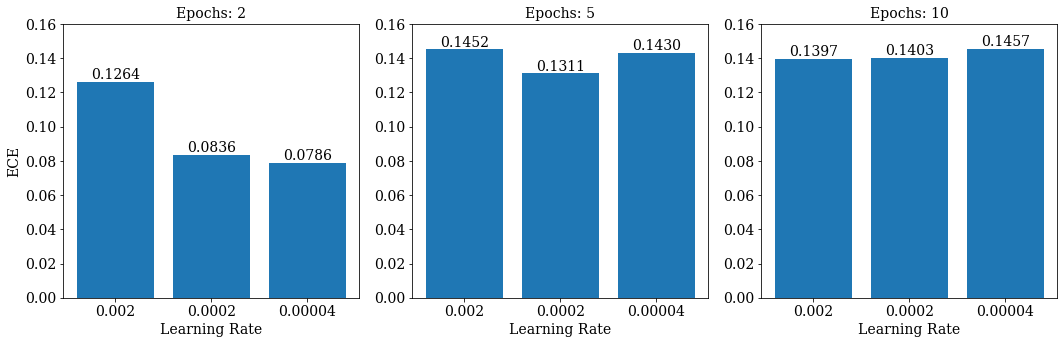

In [100]:
# for shen loss weight = 1, plot ECE per learning rate and epochs
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# bar plot for each epoch
for i, epoch in enumerate(epochs_list):
    ece_values = [results_dict[shen_loss_weight][learning_rate][epoch]['ece_score'] for learning_rate in learning_rates]
    axs[i].bar(learning_rates, ece_values)
    # add actual values on top of bars
    for j, ece in enumerate(ece_values):
        axs[i].text(j, ece, f"{ece:.4f}", ha='center', va='bottom')
    axs[i].set_title(f"Epochs: {epoch}")
    axs[i].set_xlabel("Learning Rate")
    if i == 0:
        axs[i].set_ylabel("ECE")
    axs[i].set_ylim([0, 0.16])
plt.tight_layout()